# DV8 standard deviation

In [1]:
import xarray as xr
import numpy as np
import pandas as pd
import dask
import cartopy.feature as cfeature
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import intake
import cartopy.crs as ccrs
from tempfile import TemporaryDirectory
from getpass import getuser
from pathlib import Path
from dask.distributed import Client, LocalCluster
import subprocess
import re
import sys
sys.path.append('/home/b/b382616/notebooks_home/MHW/spot_the_blob')

import spot_the_blOb.hot_to_blOb as hot

import warnings
warnings.filterwarnings('ignore')

/home/b/b382616/.local/lib/python3.9/site-packages/dask/dataframe/_pyarrow_compat.py:15: FutureWarning: Minimal version of pyarrow will soon be increased to 14.0.1. You are using 11.0.0. Please consider upgrading.
  warnings.warn(


In [2]:

import dask
from dask.distributed import Client, LocalCluster
import bokeh

dask.config.config.get('distributed').get('dashboard').update({'link':'{JUPYTERHUB_SERVICE_PREFIX}/proxy/{port}/status'})
cluster = LocalCluster(n_workers=32, threads_per_worker=4)
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /user/b382616/levante-spawner-preset//proxy/36141/status,
Dashboard: /user/b382616/levante-spawner-preset//proxy/36141/status,Workers: 32
Total threads: 128,Total memory: 235.37 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46325,Workers: 32
Dashboard: /user/b382616/levante-spawner-preset//proxy/36141/status,Total threads: 128
Started: Just now,Total memory: 235.37 GiB
Comm: tcp://127.0.0.1:40251,Total threads: 4
Dashboard: /user/b382616/levante-spawner-preset//proxy/46165/status,Memory: 7.36 GiB
Nanny: tcp://127.0.0.1:39075,


# SST

In [3]:
cat = intake.open_catalog("https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/eerie.yaml")

dat = cat['dkrz.disk.observations.OSTIA.OSTIA.daily']#-output'][model][expid][version]['ocean'][gridspec]
dat

daily:
  args:
    consolidated: false
    urlpath: /work/bk1377/b382473/obs/OSTIA/original.zarr
  description: OSTIA SST and sea ice at 1/20 degree from https://data.marine.copernicus.eu/product/SST_GLO_SST_L4_REP_OBSERVATIONS_010_011/description
  driver: intake_xarray.xzarr.ZarrSource
  metadata:
    catalog_dir: https://raw.githubusercontent.com/eerie-project/intake_catalogues/main/dkrz/disk/observations/OSTIA


In [4]:
sst = dat(chunks={}).to_dask()


# regrid to low res

In [5]:
sst=sst['sst'].coarsen(lat=5, lon=5,boundary='pad').mean()

In [6]:
sst=sst.isel(time=slice(0,13879))

# create SSTA

In [21]:
# Process Data using `hot_to_blOb` helper functions:

extreme_events_ds = hot.preprocess_data(sst,detrend_orders=[1,2], std_normalise=False, threshold_percentile=95)
ssta=extreme_events_ds['dat_detrend']
ssta=ssta.isel(time=slice(0,13879))

In [22]:
#slice time to same length as icon
ssta=ssta.isel(time=slice(0,13879))

# SST

In [9]:
sst_std = sst.std(dim="time")
#sst_std=sst_std.compute()

In [80]:
sst_std=sst_std.compute()

Task exception was never retrieved
future: <Task finished name='Task-9689349' coro=<Client._gather.<locals>.wait() done, defined at /home/b/b382616/.local/lib/python3.9/site-packages/distributed/client.py:2396> exception=AllExit()>
Traceback (most recent call last):
  File "/home/b/b382616/.local/lib/python3.9/site-packages/distributed/client.py", line 2405, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-9689350' coro=<Client._gather.<locals>.wait() done, defined at /home/b/b382616/.local/lib/python3.9/site-packages/distributed/client.py:2396> exception=AllExit()>
Traceback (most recent call last):
  File "/home/b/b382616/.local/lib/python3.9/site-packages/distributed/client.py", line 2405, in wait
    raise AllExit()
distributed.client.AllExit
Task exception was never retrieved
future: <Task finished name='Task-9689351' coro=<Client._gather.<locals>.wait() done, defined at /home/b/b382616/.local/lib/python3.9

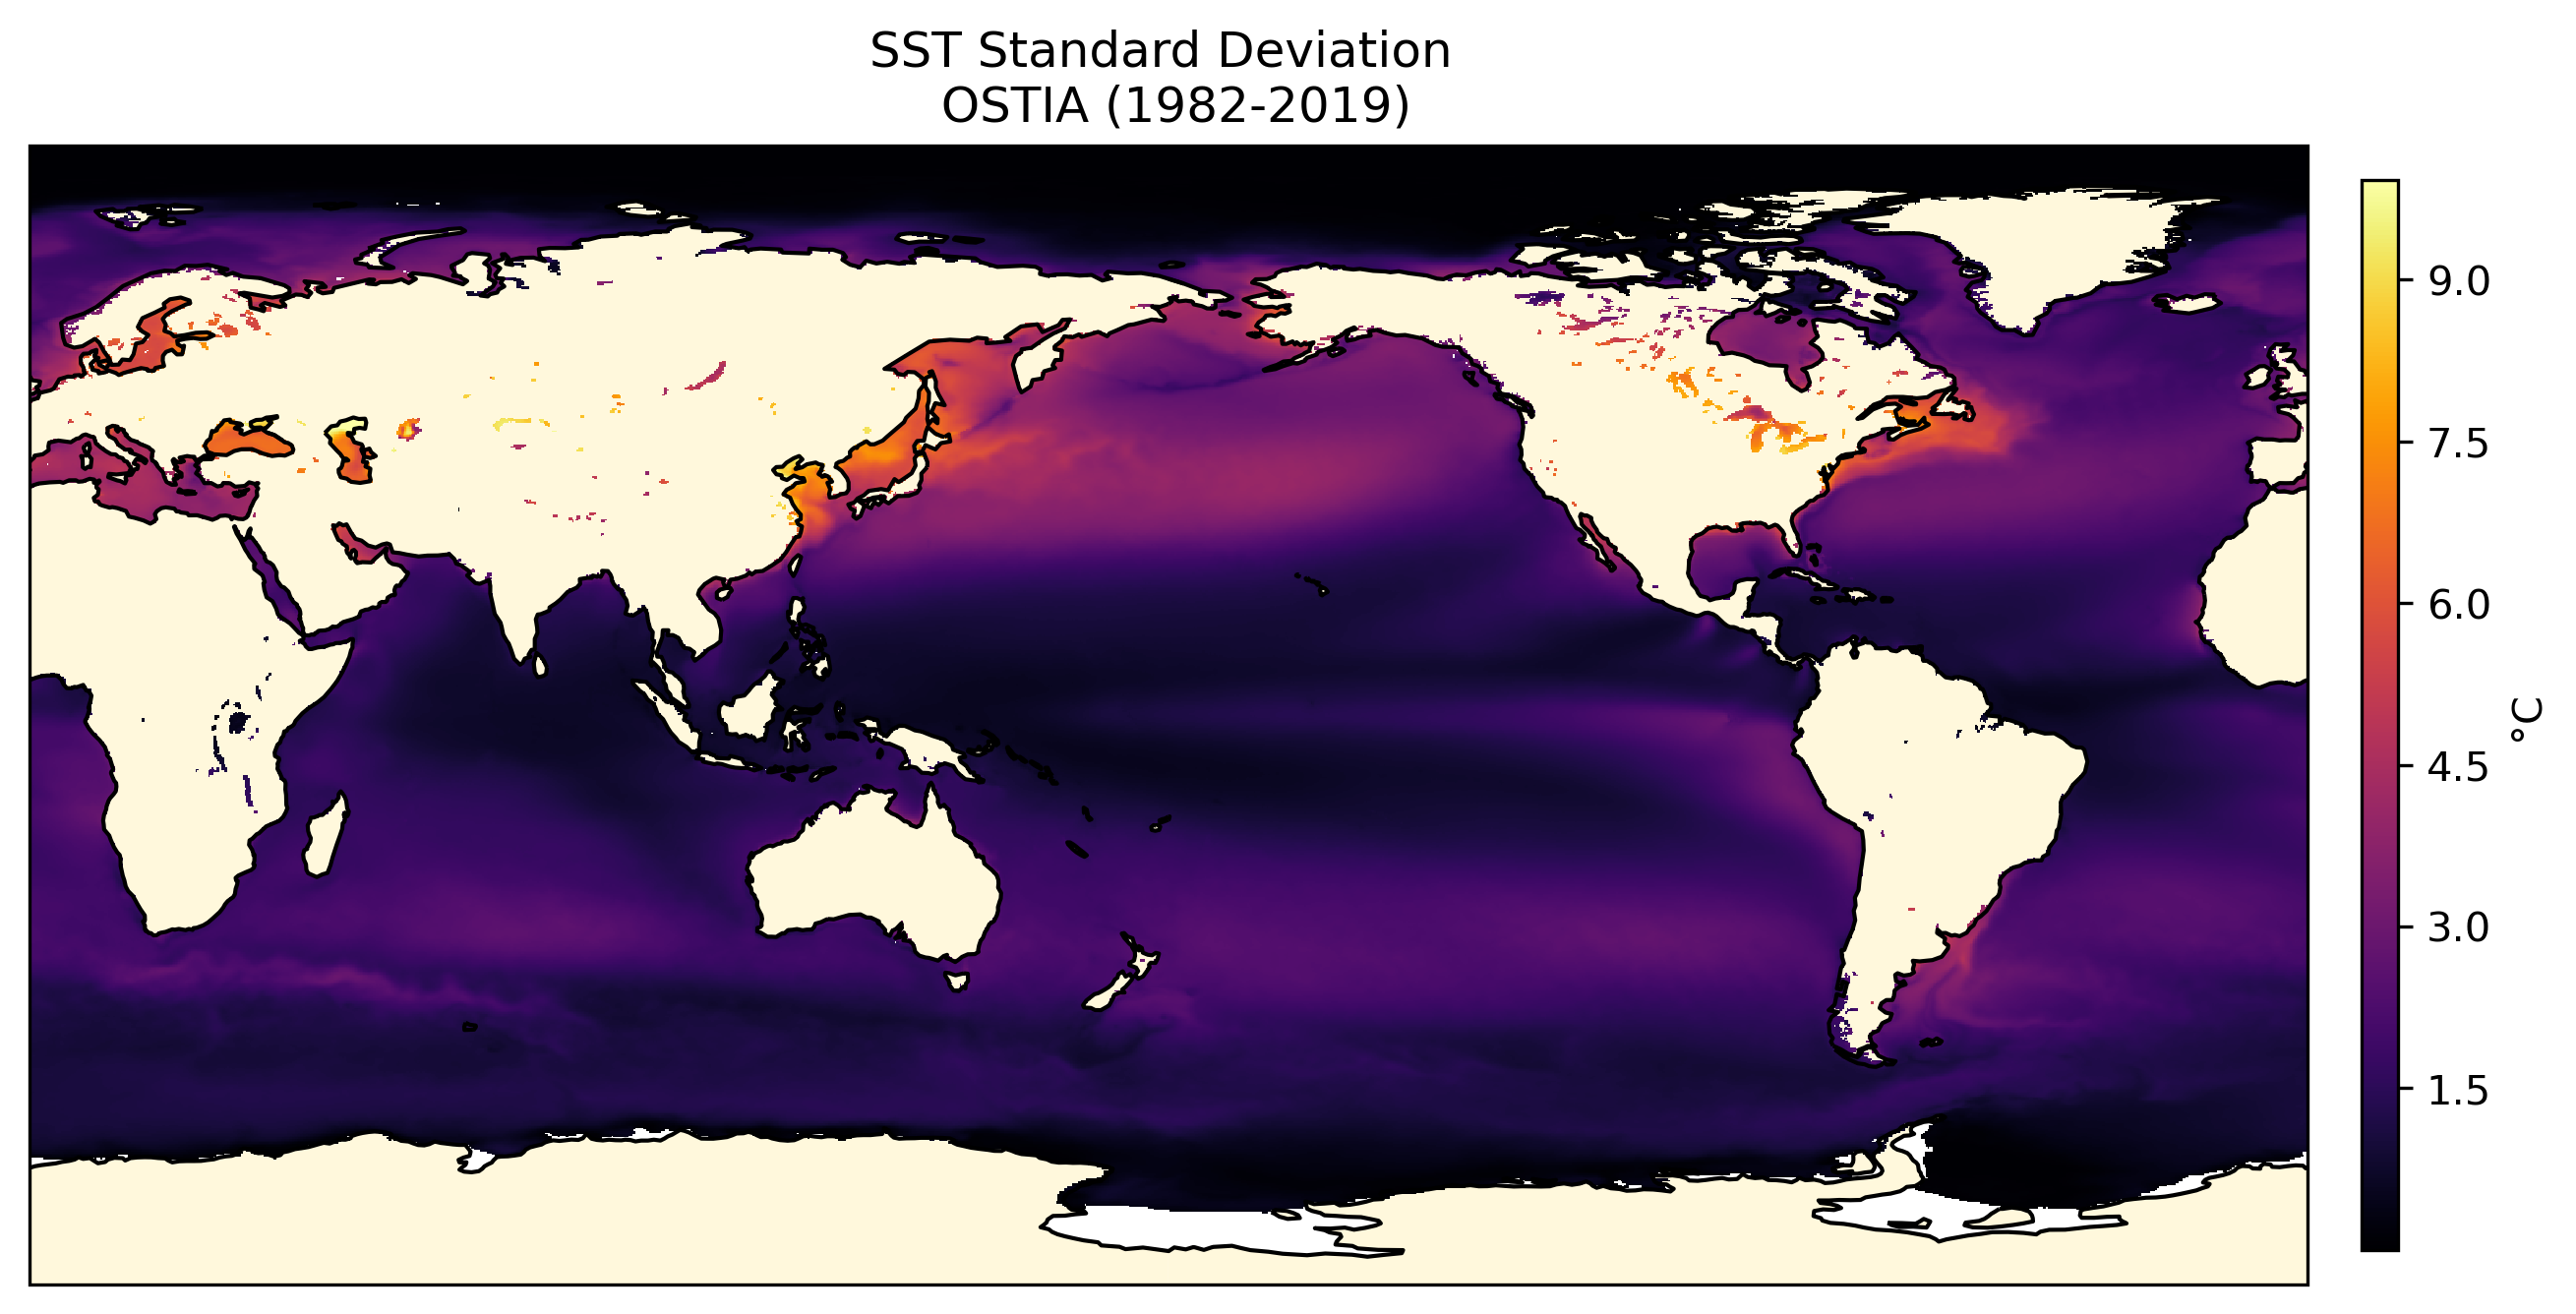

In [83]:


fig = plt.figure(figsize=(12, 6),dpi=300)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))  
ax.set_global()  
ax.add_feature(cfeature.LAND, facecolor='cornsilk')

ax.coastlines()
pcm = ax.pcolormesh(sst_std.lon, sst_std.lat, sst_std, cmap='inferno', vmax=9.921022,transform=ccrs.PlateCarree())


cbar = fig.colorbar(pcm, ax=ax, orientation="vertical", shrink=0.8, pad=0.02, aspect=30)

# Increase the number of ticks
cbar.set_ticks(ticker.MaxNLocator(nbins=8))  # Adjust nbins as needed

cbar.set_label("°C")

# Title
plt.title("SST Standard Deviation \n OSTIA (1982-2019)")

plt.show()


# SSTA SDV

In [10]:
ssta_std = ssta.std(dim="time")
ssta_std=ssta_std.compute()

2025-03-03 13:55:22,435 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 5.99 GiB -- Worker memory limit: 7.36 GiB
2025-03-03 13:55:22,501 - distributed.worker.memory - WARNING - Worker is at 82% memory usage. Pausing worker.  Process memory: 6.08 GiB -- Worker memory limit: 7.36 GiB
2025-03-03 13:55:22,866 - distributed.worker.memory - WARNING - Worker is at 68% memory usage. Resuming worker. Process memory: 5.07 GiB -- Worker memory limit: 7.36 GiB
2025-03-03 13:55:23,183 - distributed.worker.memory - WARNING - Worker is at 65% memory usage. Resuming worker. Process memory: 4.80 GiB -- Worker memory limit: 7.36 GiB
2025-03-03 13:55:23,188 - distributed.worker.memory - WARNING - Worker is at 81% memory usage. Pausing worker.  Process memory: 6.03 GiB -- Worker memory limit: 7.36 GiB
2025-03-03 13:55:24,378 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 5.93 GiB -- Worker mem

In [11]:
ssta_std=ssta_std.compute()

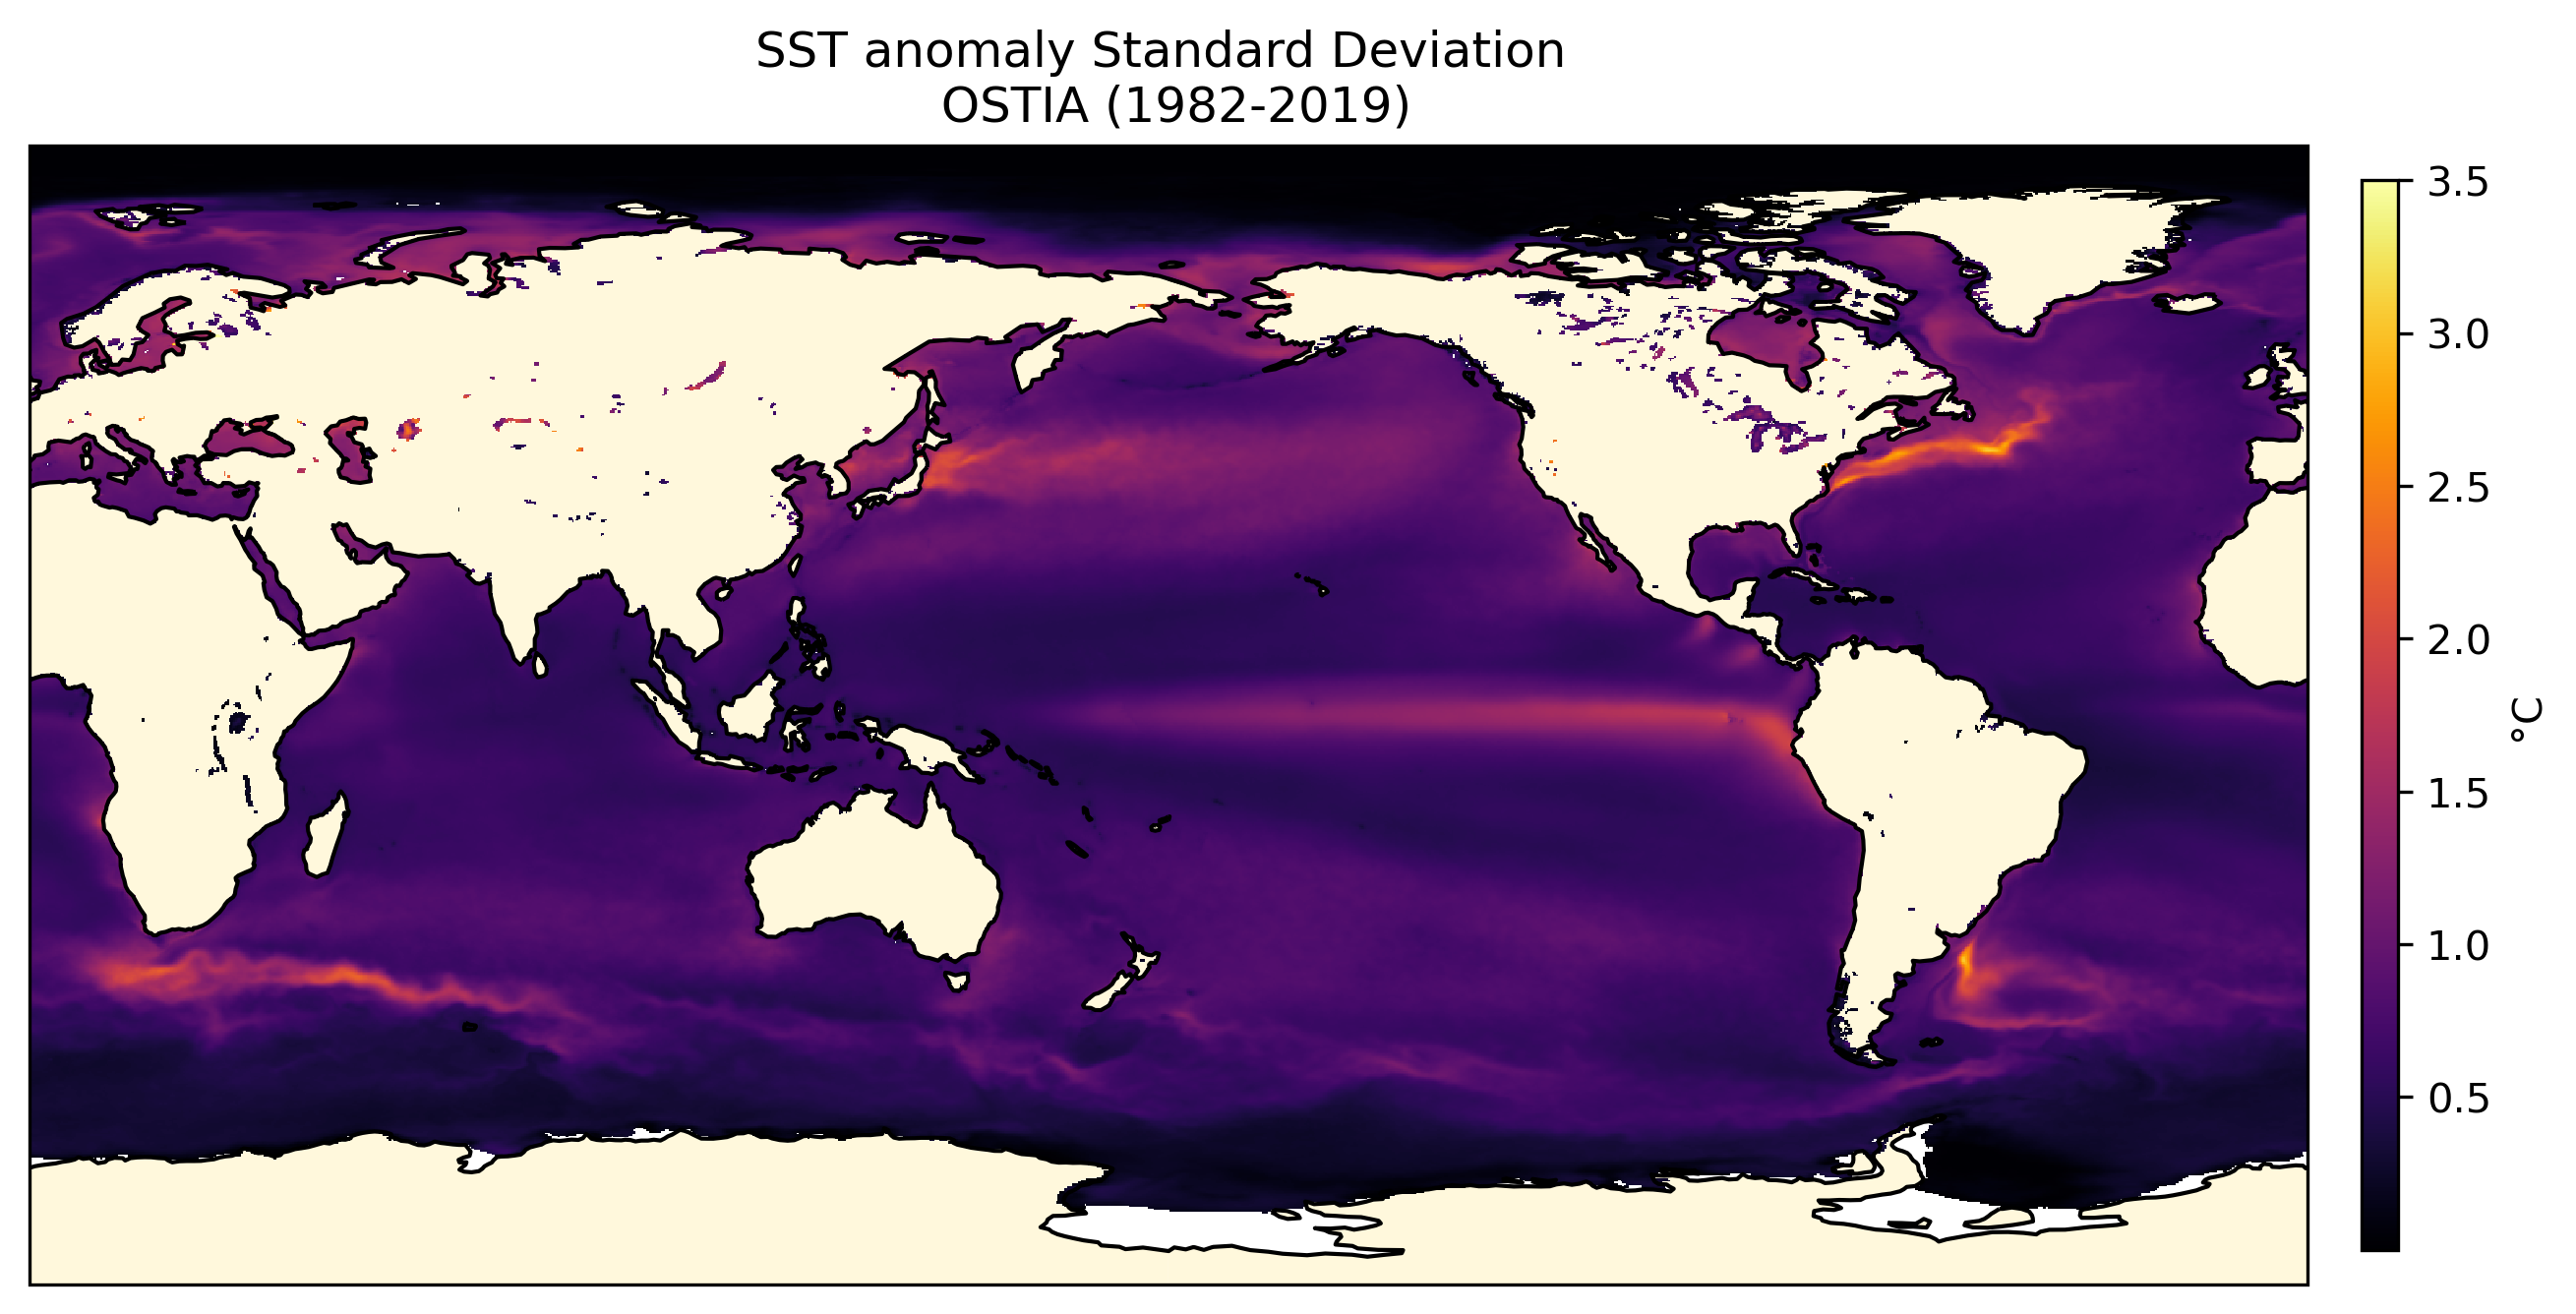

In [19]:


fig = plt.figure(figsize=(12, 6),dpi=300)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))  
ax.set_global()  
ax.add_feature(cfeature.LAND, facecolor='cornsilk')

ax.coastlines()
pcm = ax.pcolormesh(ssta_std.lon, ssta_std.lat, ssta_std,vmax=3.5, cmap='inferno', transform=ccrs.PlateCarree())


cbar = fig.colorbar(pcm, ax=ax, orientation="vertical", shrink=0.8, pad=0.02, aspect=30)

# Increase the number of ticks
cbar.set_ticks(ticker.MaxNLocator(nbins=8))  # Adjust nbins as needed

cbar.set_label("°C")

# Title
plt.title("SST anomaly Standard Deviation \n OSTIA (1982-2019)")

plt.show()


In [16]:
ssta_mean=ssta.mean(dim='time')
ssta_mean=ssta_mean.persist()


In [14]:
ssta_mean=ssta_mean.compute()

2025-03-03 14:36:38,789 - distributed.worker.memory - WARNING - Worker is at 80% memory usage. Pausing worker.  Process memory: 5.94 GiB -- Worker memory limit: 7.36 GiB
2025-03-03 14:36:38,800 - distributed.worker.memory - WARNING - Worker is at 76% memory usage. Resuming worker. Process memory: 5.64 GiB -- Worker memory limit: 7.36 GiB


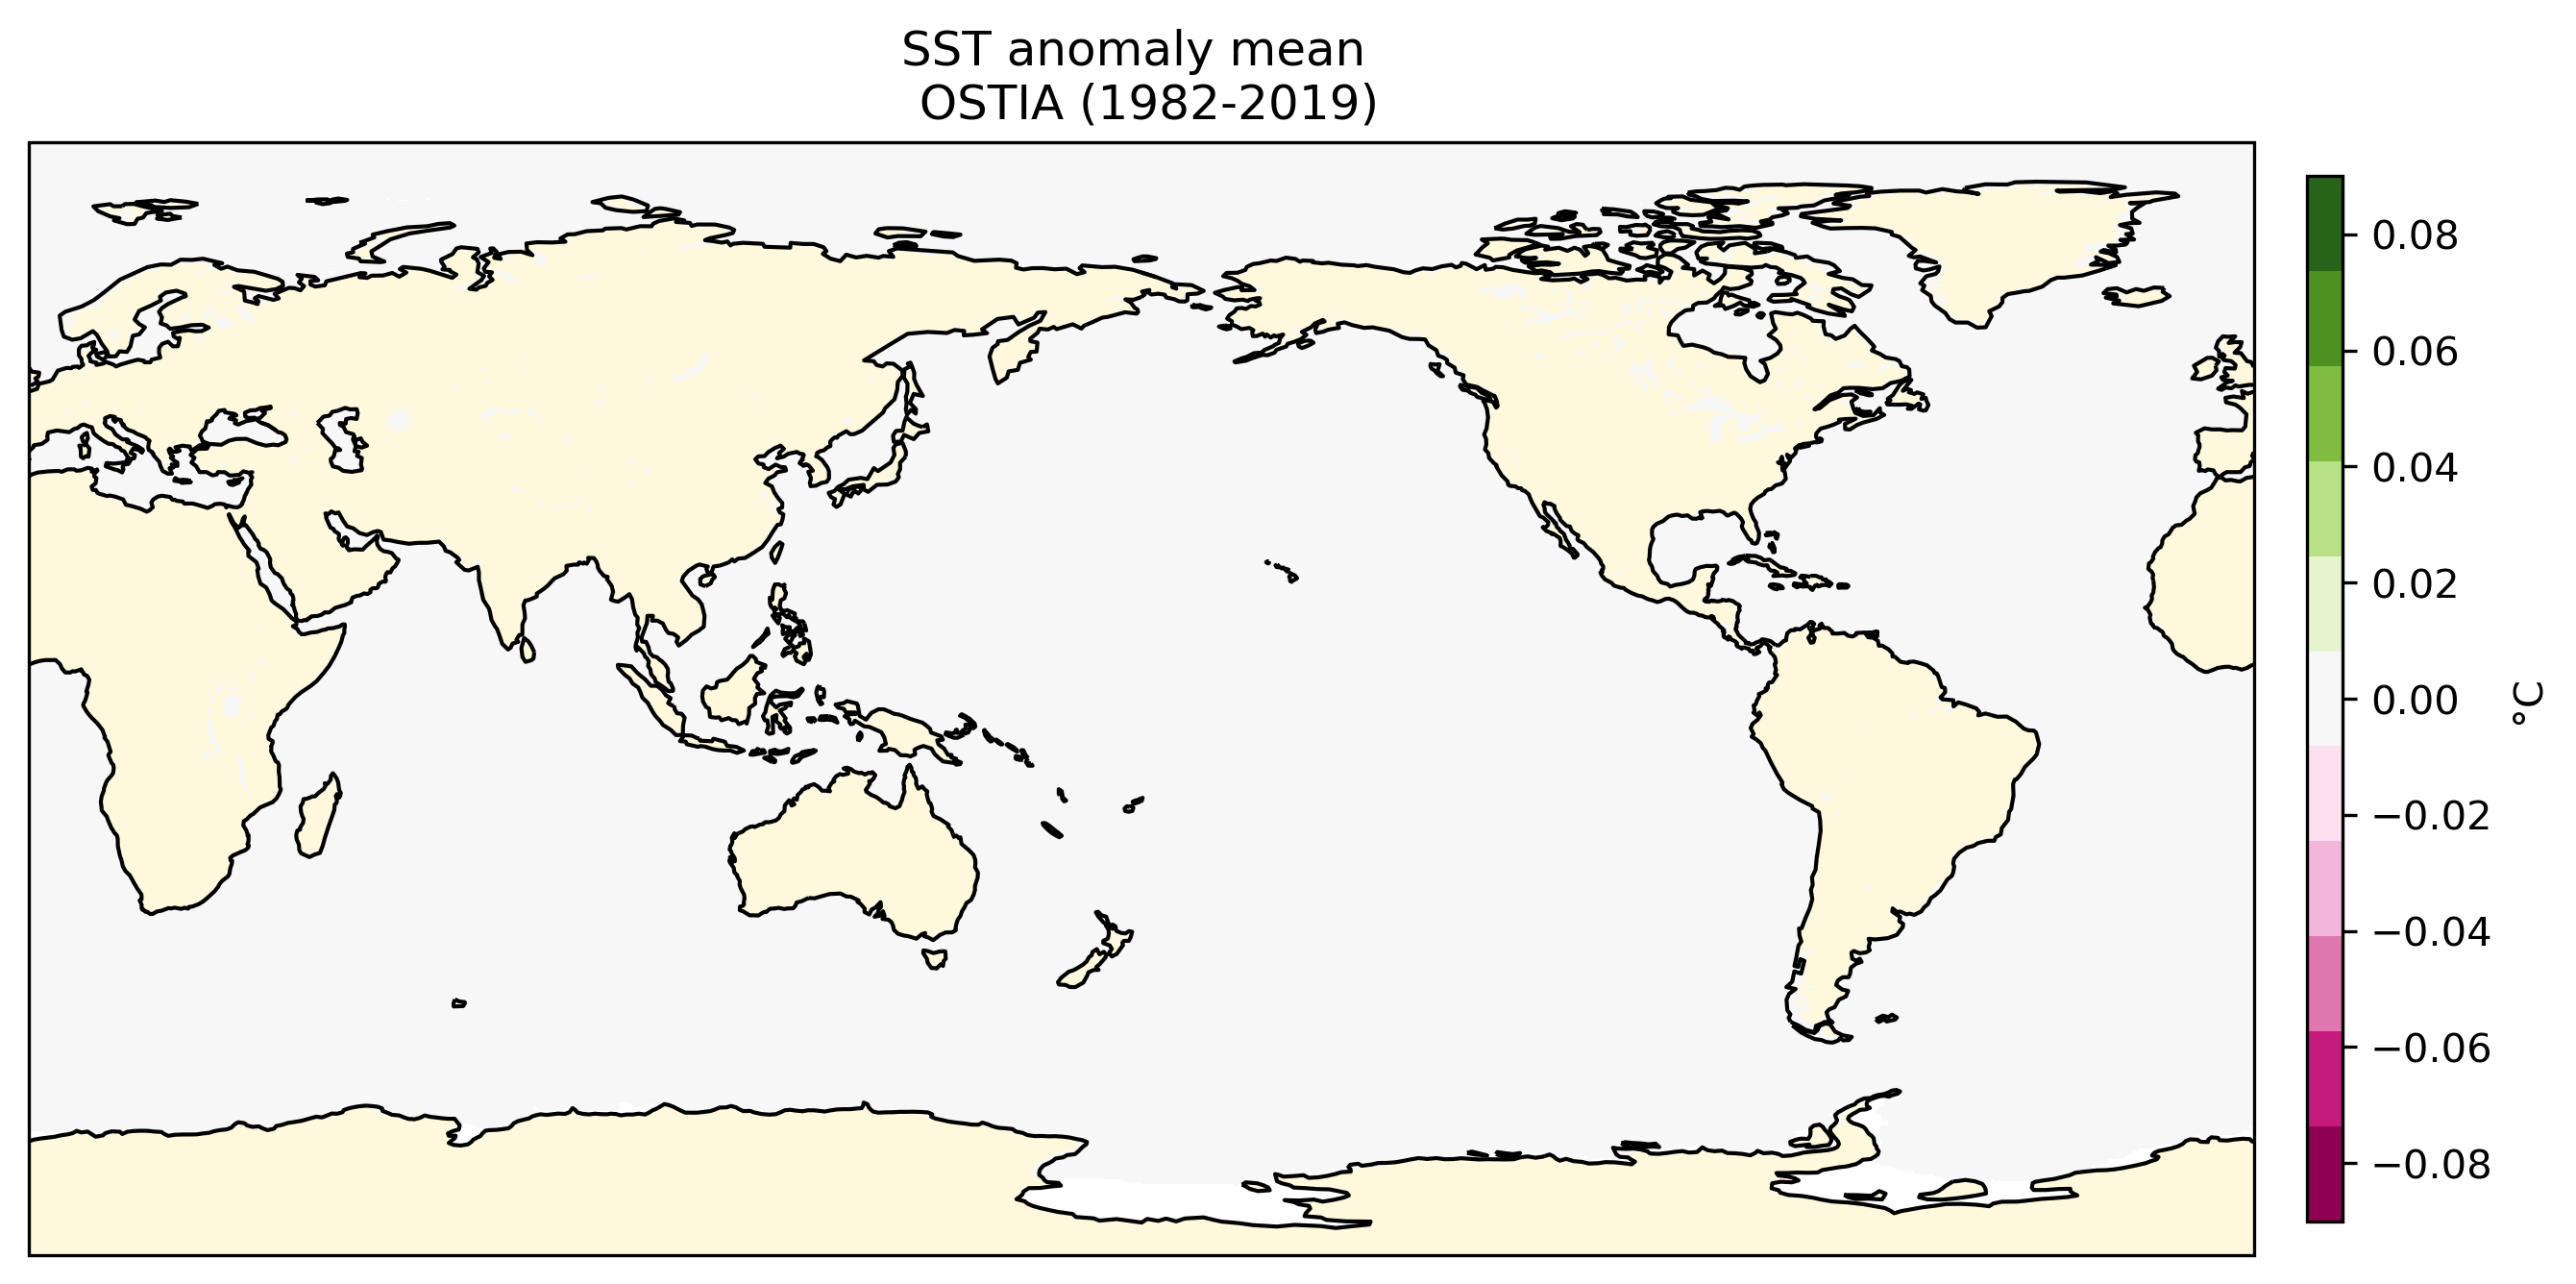

In [22]:
var=ssta_mean

fig = plt.figure(figsize=(12, 6),dpi=300)
ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180))  
ax.set_global()  
ax.add_feature(cfeature.LAND, facecolor='cornsilk')
cmap = plt.get_cmap('PiYG', 11) 
ax.coastlines()
pcm = ax.pcolormesh(var.lon, var.lat, var, cmap=cmap,vmin=-0.09, vmax=0.09,transform=ccrs.PlateCarree())


cbar = fig.colorbar(pcm, ax=ax, orientation="vertical", shrink=0.8, pad=0.02, aspect=30)

# Increase the number of ticks
cbar.set_ticks(ticker.MaxNLocator(nbins=10))  # Adjust nbins as needed

cbar.set_label("°C")

# Title
plt.title("SST anomaly mean \n OSTIA (1982-2019)")

plt.show()


# SSTA different regions study

In [23]:
# Example: Global SSTA (scaled ×10)
global_anom = ssta.mean(dim=['lat', 'lon'])

# AMV Region (scaled ×3)
#amv_anom = ssta.sel(lat=slice(0, 65), lon=slice(105, 172.5)).mean(dim=['lat', 'lon'])

# Gulf Stream Region (customize coordinates)
gulf_stream_anom = ssta.sel(lat=slice(25, 50), lon=slice(100, 125)).mean(dim=['lat', 'lon'])

Agulhas_an=ssta.sel(lat=slice(-40,-25),lon=slice(195,225)).mean(dim=['lat', 'lon'])

Kuroshio_an=ssta.sel(lat=slice(25,40),lon=slice(310,330)).mean(dim=['lat', 'lon'])


In [25]:
global_anom=global_anom.compute()

2025-03-04 14:49:20,026 - distributed.scheduler - WARNING - Detected different `run_spec` for key 'original-open_dataset-sst-167d0dca1a6a0bcb7e8d90cae040cb8b' between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: released
old run_spec: (<function execute_task at 0x7fff0e8a31f0>, (ImplicitToExplicitIndexingAdapter(array=CopyOnWriteArray(array=LazilyIndexedArray(array=_ElementwiseFunctionArray(_ElementwiseFunctionArray(LazilyIndexedArray(array=<xarray.backends.zarr.ZarrArrayWrapper object at 0x7ffc9439f200>, key=BasicIndexer((slice(None, None, None), slice(None, None, None), slice(None, None, None)))), func=functools.partial(<function _apply_mask at 0x7f

In [52]:
global_sst = sst.mean(dim=['lat', 'lon'])
global_sst=global_sst.compute()

In [26]:
gulf_stream_anom=gulf_stream_anom.compute()

2025-03-04 14:56:15,195 - distributed.scheduler - WARNING - Detected different `run_spec` for key 'original-open_dataset-sst-167d0dca1a6a0bcb7e8d90cae040cb8b' between two consecutive calls to `update_graph`. This can cause failures and deadlocks down the line. Please ensure unique key names. If you are using a standard dask collections, consider releasing all the data before resubmitting another computation. More details and help can be found at https://github.com/dask/dask/issues/9888. 
Debugging information
---------------------
old task state: released
old run_spec: (<function execute_task at 0x7fff0e8a31f0>, (ImplicitToExplicitIndexingAdapter(array=CopyOnWriteArray(array=LazilyIndexedArray(array=_ElementwiseFunctionArray(_ElementwiseFunctionArray(LazilyIndexedArray(array=<xarray.backends.zarr.ZarrArrayWrapper object at 0x7ffc9439f200>, key=BasicIndexer((slice(None, None, None), slice(None, None, None), slice(None, None, None)))), func=functools.partial(<function _apply_mask at 0x7f

In [35]:
gulf_stream_anom=gulf_stream_anom.compute()
#amv_anom=amv_anom.compute()
global_anom=global_anom.compute()
Kuroshio_an=Kuroshio_an.compute()
Agulhas_an=Agulhas_an.compute()

2025-03-03 15:49:13,059 - distributed.worker.memory - WARNING - Worker is at 83% memory usage. Pausing worker.  Process memory: 6.17 GiB -- Worker memory limit: 7.36 GiB
2025-03-03 15:49:13,065 - distributed.worker.memory - WARNING - Worker is at 63% memory usage. Resuming worker. Process memory: 4.68 GiB -- Worker memory limit: 7.36 GiB


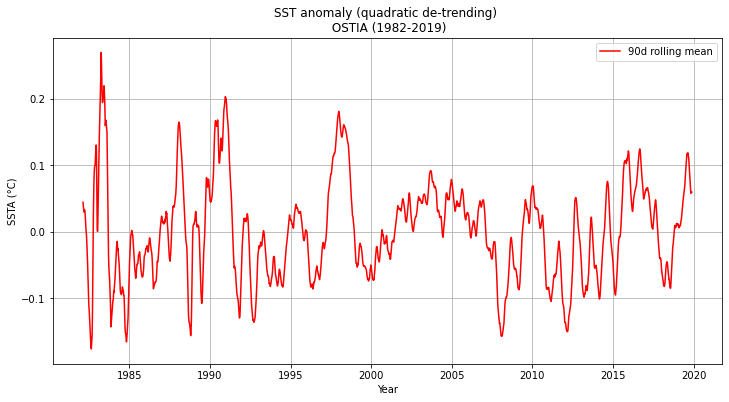

In [34]:

plt.figure(figsize=(12, 6))

# Raw global data (grey)
#plt.plot(ssta['time'], global_anom, color='grey', alpha=0.3, label='Global Raw')

# SSTa
global_smooth = global_anom.rolling(time=90, center=True).mean()
plt.plot(ssta_3['time'], global_smooth, color='red', linewidth=1.5, label='90d rolling mean')

#TOTAL SST
#global_smooth_sst = global_sst.rolling(time=90, center=True).mean()
#plt.plot(sst_gr['time'], global_smooth_sst, color='black', linewidth=1.5, label='Global SST')

#gulf stream
#gulf_stream_anom_smooth = gulf_stream_anom.rolling(time=90, center=True).mean()
#plt.plot(ssta['time'], gulf_stream_anom_smooth, color='red', linewidth=1.5, label='Gulf Stream')

#gulf stream
#Agulhas_an_smooth = Agulhas_an.rolling(time=90, center=True).mean()
#plt.plot(ssta['time'], Agulhas_an_smooth, color='purple', linewidth=1.5, label='Agulhas current')

#gulf stream
#Kuroshio_an_anom_smooth = Kuroshio_an.rolling(time=90, center=True).mean()
#plt.plot(ssta['time'], Kuroshio_an_anom_smooth, color='red', linewidth=1.5, label='Kuroshio current')

# Add other regions (NINO 3.4, NE Pacific, Gulf Stream, etc.)
plt.xlabel('Year')
plt.ylabel('SSTA (°C)')
plt.title('SST anomaly (quadratic de-trending) \n OSTIA (1982-2019)')
plt.legend()
plt.grid(True)
plt.show()

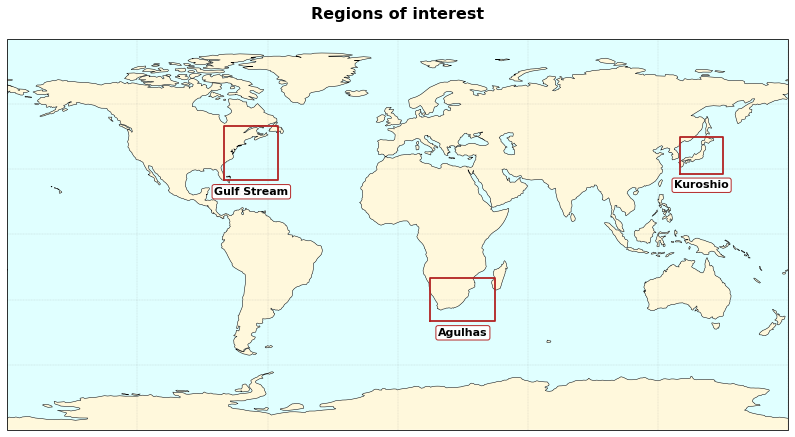

In [118]:

# Define regions of interest with bounding boxes
regions = {
    'Gulf Stream': {'lon': (-80, -55), 'lat': (25, 50)},
    'Agulhas': {'lon': (15, 45), 'lat': (-40, -20)},
    'Kuroshio': {'lon': (130, 150), 'lat': (28, 45)}
}

# Create figure and axis
fig = plt.figure(figsize=(14, 8))
ax = fig.add_subplot(1, 1, 1, projection=ccrs.PlateCarree())

# Add map features
ax.add_feature(cfeature.LAND, facecolor='cornsilk')
ax.add_feature(cfeature.COASTLINE, linewidth=0.5)
ax.add_feature(cfeature.OCEAN, facecolor='lightcyan')

# Plot regions with labels below
for name, box in regions.items():
    # Draw rectangle
    ax.plot(
        [box['lon'][0], box['lon'][1], box['lon'][1], box['lon'][0], box['lon'][0]],
        [box['lat'][0], box['lat'][0], box['lat'][1], box['lat'][1], box['lat'][0]],
        color='firebrick', linewidth=1.8, transform=ccrs.PlateCarree()
    )
    
    # Calculate label position (centered below rectangle)
    label_lon = np.mean(box['lon'])
    label_lat = box['lat'][0] - 3  # 3 degrees below southern boundary
    
    # Add label
    ax.text(
        label_lon,
        label_lat,
        name,
        horizontalalignment='center',
        verticalalignment='top',
        transform=ccrs.PlateCarree(),
        fontsize=11,
        fontweight='bold',
        bbox=dict(
            facecolor='white', 
            alpha=0.95,
            boxstyle='round,pad=0.2',
            edgecolor='firebrick'
        )
    )

# Set global extent and add subtle grid
ax.set_global()
ax.gridlines(linewidth=0.3, color='gray', linestyle='--', alpha=0.5)

# Title
plt.title('Regions of interest', fontsize=16, pad=20, fontweight='bold')

plt.show()

# ICON vs OSTIA

In [31]:
file_name = Path('/scratch') / getuser()[0] / getuser() / 'mhws' / 'extreme_events_binary_ord2.zarr'
chunk_size = {'time': 25, 'lat': -1, 'lon': -1}
ds = xr.open_zarr(str(file_name), chunks=chunk_size)
sstaic=ds['dat_detrend']

In [32]:
sstaic_m=sstaic.mean(dim={'lat','lon'})

In [33]:
sstaic_m=sstaic_m.compute()

ValueError: too many values to unpack (expected 2)

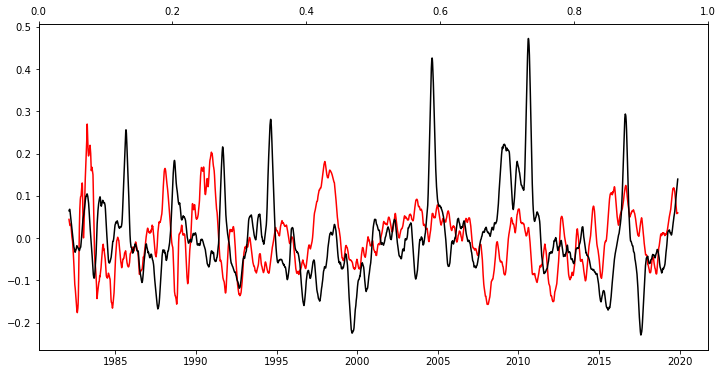

In [48]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# OSTIA
global_smooth = global_anom.rolling(time=90, center=True).mean()
plt.plot(ssta['time'], global_smooth, color='red', linewidth=1.5, label='OSTIA-90d rolling mean')

# ICON
global_smooth_ic = sstaic_m.rolling(time=90, center=True).mean()
plt.plot(ssta['time'], global_smooth_ic, color='black', linewidth=1.5, label='ICON-90d rolling mean')

# Add second x-axis at the top
ax = plt.gca()
ax_top = ax.twiny()  # Create a twin axis sharing the same y-axis
ax_top.set_xlim(sstaic['time'])  # Match the limits of the bottom x-axis
ax_top.set_xlabel('ICON Time')

# Labels and styling
plt.xlabel('OSTIA Time')
plt.ylabel('SSTA (°C)')
plt.title('SST Anomaly (Quadratic De-trending)')
plt.legend()
plt.grid(True)

plt.show()


In [ ]:
fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()

X = np.linspace(0,1,1000)
Y = np.cos(X*20)

ax1.plot(X,Y)
ax1.set_xlabel(r"Original x-axis: $X$")

new_tick_locations = np.array([.2, .5, .9])

def tick_function(X):
    V = 1/(1+X)
    return ["%.3f" % z for z in V]

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(new_tick_locations)
ax2.set_xticklabels(tick_function(new_tick_locations))
ax2.set_xlabel(r"Modified x-axis: $1/(1+X)$")
plt.show()